# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [30]:
#!apt-get update && apt-get install -y python3-opencv

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2564 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]   
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3002 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1468 kB]
Get:14 http://security.ubuntu.com

In [31]:
#pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [32]:
#!pip install sklearn

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold

import torchvision.transforms as transforms

import albumentations
from albumentations.pytorch import ToTensorV2

## Set Arguments & hyperparameters

In [2]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [4]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 15
INPUT_SHAPE = 512

####
k = 5


os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(384, 384) (384, 384, 3)


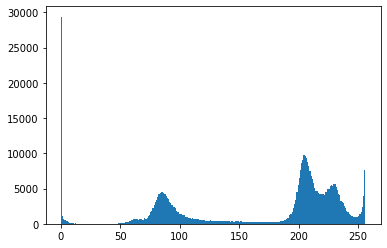

In [5]:
import matplotlib.pyplot as plt

img = cv2.imread('data/train/1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img2 = cv2.imread('data/train/1.png', cv2.IMREAD_GRAYSCALE|cv2.IMREAD_IGNORE_ORIENTATION)

print(img2.shape, img.shape)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.hist(img.ravel(), 256, [0,256])
plt.show()

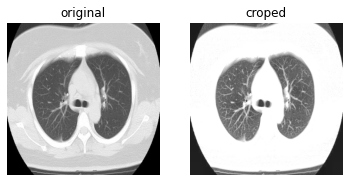

In [6]:

transform = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.CenterCrop(512, 512),
    albumentations.RandomBrightnessContrast(brightness_by_max=False),
    albumentations.CLAHE(clip_limit=(1,2))
])

augmentations = transform(image = img)
augmentation_img = augmentations["image"]

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img)
ax1.set_title('original')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(augmentation_img)
ax2.set_title('croped')
ax2.axis("off")
 
plt.show()

## Dataloader

#### Train & Validation Set loader

In [48]:
# torch.utils.data 안의 Dataset 상속
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.8)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.8):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        
        self.transform = albumentations.Compose([albumentations.Resize(512, 512), 
                                                 albumentations.RandomCrop(500, 500),
                                                  # Same with transforms.RandomHorizontalFlip()
                                                 
                                                albumentations.OneOf([
                                                        albumentations.GridDistortion(),
                                                        albumentations.RandomBrightnessContrast(p=0.8)
                                                ]),
                                                albumentations.HorizontalFlip(),
                                                albumentations.VerticalFlip(),
                                                albumentations.RandomBrightness(),
                                                albumentations.CLAHE(),
                                                # albumentations.RandomBrightnessContrast(brightness_by_max=False),
                                                # albumentations.CLAHE(clip_limit=(1,2)),
                                                 # Normalize default 값을 쓰는데 각 채널의 평균, 표준편차를 구할 수 있나?
                                                albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                albumentations.pytorch.transforms.ToTensorV2()])
#         self.transform = transforms.Compose([transforms.Resize(self.input_shape),
#                 # ToTensor() -> torch.Float.Tensor 로 바꾸면서 (C x H x W) 순서와 0.0 ~ 1.0사이의 값들로 변환
#                                              transforms.ToTensor(),
#                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
         
        

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)
    # 인덱싱 을 통하여 이미지 전처리 가능하게
    def __getitem__(self, index):
        # data에 db의 데이터 프레임의 값만 복사해와서 할당
        data = copy.deepcopy(self.db.loc[index])

        # Loading image (cvimg type -> numpy의 ndarray type (height, width, channel)
        # 데이터가 다 흑백인데 왜 cv2.IMREAD_COLOR 쓰는가? IMREAD_GRAYSCALE 써도 되는거 아닌가..
        # cv2.IMREAD_IGNORE_ORIENTATION -> exif의 방향데이터 사용 X
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        # cvimg 가 numpy의 ndarray type 형식인지 확인 -> 어떤 경우 에러를 뱉어내나..?
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        # trans_image = self.transform(Image.fromarray(cvimg))
        # image = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
        trans_image = self.transform(image = cvimg)
        trans_image = trans_image['image']

        return trans_image, data['COVID']


## Model

In [49]:
# import torch.nn.functional as F

# class custom_CNN(nn.Module):
#     def __init__(self, num_classes):
#         super(custom_CNN, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        
#         self.fc1 = nn.Linear(in_features=25*29*29, out_features=128)
#         self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
#         x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        
#         x = torch.flatten(x,1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        
#         output = self.softmax(x)
        
#         return output

In [50]:
# import torchvision.models as models

# class resnet(nn.Module):
#     def __init__(self, numclasses):
#         super(resnet, self).__init__()
#         self.model = models.resnet18(pretrained=False)
#         self.model.fc = nn.Linear(self.model.fc.in_features, numclasses)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, input_img):
#         x = self.model(input_img)
#         x = self.softmax(x)
#         return x

In [51]:
# import torchvision.models as models

# class resnet34(nn.Module):
#     def __init__(self, numclasses):
#         super(resnet34, self).__init__()
#         self.model = models.resnet34(pretrained=False)
#         self.model.fc = nn.Linear(self.model.fc.in_features, numclasses)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, input_img):
#         x = self.model(input_img)
#         x = self.softmax(x)
#         return x

In [52]:
import torchvision.models as models

class resnet(nn.Module):
    def __init__(self, numclasses):
        super(resnet, self).__init__()
        self.model = models.resnet34(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, numclasses)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

## Utils
### EarlyStopper

In [53]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [54]:
class Trainer_f():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, fold, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Fold{fold +1} /Epoch{epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, fold, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Fold{fold + 1} Epoch/{epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

In [55]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [56]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [57]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
###
dataset = ConcatDataset([train_dataset, validation_dataset])
splits=KFold(n_splits=k,shuffle=True, random_state=42)
####
train_dataloader = DataLoader(train_dataset,num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, num_workers=4,batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 516 Val set samples: 130


In [58]:
for i in splits.split(np.arange(len(dataset))):
    print(i)

(array([  0,   1,   3,   4,   5,   7,   8,   9,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,
        32,  33,  34,  35,  36,  37,  38,  40,  42,  43,  45,  46,  47,
        48,  50,  51,  52,  53,  57,  58,  59,  61,  62,  64,  66,  67,
        68,  71,  73,  74,  75,  79,  80,  83,  84,  85,  87,  88,  89,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 103, 104,
       105, 106, 107, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 134, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153,
       154, 156, 157, 159, 160, 161, 162, 164, 166, 168, 169, 170, 171,
       172, 173, 175, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 205, 206, 207, 210, 212, 214, 216, 217, 219, 220, 222, 223,
       224, 225, 226, 228, 229, 230, 232, 233, 234, 235, 237, 2

In [59]:
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")



Feature batch shape: torch.Size([3, 500, 500])


#### Load model and other utils

In [60]:
# Load Model
model = resnet(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(dataset))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)
trainer_f = Trainer_f(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [61]:
model

resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

# K Fold

In [62]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
    

    for epoch_index in tqdm(range(EPOCHS)):


        trainer_f.train_epoch(fold, train_loader, epoch_index)     
        trainer_f.validate_epoch(fold, test_loader, epoch_index)

        
        # early_stopping check
        early_stopper.check_early_stopping(loss=trainer_f.val_mean_loss)

        if early_stopper.stop:
            print('Early stopped')
            break

        if early_stopper.save_model:           
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, 'best_k.pt')

  0% 0/20 [00:00<?, ?it/s]

Fold 1
Fold1 /Epoch0, Train loss: 0.8207966722548008, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352


  5% 1/20 [00:31<09:57, 31.45s/it]

Fold1 Epoch/0, Val loss: 0.919059619307518, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Fold1 /Epoch1, Train loss: 0.8100819401443005, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/1, Val loss: 0.9176013618707657, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Validation loss decreased 0.919059619307518 -> 0.9176013618707657


 10% 2/20 [01:05<09:39, 32.20s/it]

Fold1 /Epoch2, Train loss: 0.8124032057821751, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/2, Val loss: 0.9438464790582657, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Early stopping counter 1/15


 15% 3/20 [01:41<09:27, 33.37s/it]

Fold1 /Epoch3, Train loss: 0.8217786140739918, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/3, Val loss: 1.0140557140111923, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Early stopping counter 2/15


 20% 4/20 [02:18<09:09, 34.35s/it]

Fold1 /Epoch4, Train loss: 0.8149823062121868, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/4, Val loss: 0.9714005142450333, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Early stopping counter 3/15


 25% 5/20 [02:53<08:38, 34.56s/it]

Fold1 /Epoch5, Train loss: 0.7835660241544247, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/5, Val loss: 0.9451097398996353, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Early stopping counter 4/15


 30% 6/20 [03:29<08:09, 34.95s/it]

Fold1 /Epoch6, Train loss: 0.7748399153351784, Acc: 0.4748062015503876, F1-Macro: 0.3219448094612352
Fold1 Epoch/6, Val loss: 0.9819537103176117, Acc: 0.45384615384615384, F1-Macro: 0.3121693121693122
Early stopping counter 5/15


 35% 7/20 [04:03<07:32, 34.82s/it]

Fold1 /Epoch7, Train loss: 0.7555335089564323, Acc: 0.49806201550387597, F1-Macro: 0.3827836713204358
Fold1 Epoch/7, Val loss: 0.9130177795886993, Acc: 0.4846153846153846, F1-Macro: 0.3908664941604308
Validation loss decreased 0.9176013618707657 -> 0.9130177795886993


 40% 8/20 [04:38<06:59, 34.98s/it]

Fold1 /Epoch8, Train loss: 0.733306273818016, Acc: 0.5562015503875969, F1-Macro: 0.5070070550342739
Fold1 Epoch/8, Val loss: 0.7983413934707642, Acc: 0.5846153846153846, F1-Macro: 0.5501153550371699
Validation loss decreased 0.9130177795886993 -> 0.7983413934707642


 45% 9/20 [05:14<06:28, 35.31s/it]

Fold1 /Epoch9, Train loss: 0.7001588866114616, Acc: 0.6027131782945736, F1-Macro: 0.5887742923675607
Fold1 Epoch/9, Val loss: 0.8720510303974152, Acc: 0.5692307692307692, F1-Macro: 0.5512820512820512
Early stopping counter 1/15


 50% 10/20 [05:48<05:48, 34.85s/it]

Fold1 /Epoch10, Train loss: 0.6891235336661339, Acc: 0.6589147286821705, F1-Macro: 0.6584991652001264
Fold1 Epoch/10, Val loss: 0.8914550840854645, Acc: 0.6538461538461539, F1-Macro: 0.6513499016627928
Early stopping counter 2/15


 55% 11/20 [06:24<05:15, 35.05s/it]

Fold1 /Epoch11, Train loss: 0.6735175848007202, Acc: 0.6375968992248062, F1-Macro: 0.6361085655454863
Fold1 Epoch/11, Val loss: 0.8391846269369125, Acc: 0.6153846153846154, F1-Macro: 0.6150201374081972
Early stopping counter 3/15


 60% 12/20 [06:59<04:40, 35.09s/it]

Fold1 /Epoch12, Train loss: 0.689425278455019, Acc: 0.6317829457364341, F1-Macro: 0.6273943447856491
Fold1 Epoch/12, Val loss: 0.7787531316280365, Acc: 0.6846153846153846, F1-Macro: 0.649779880412642
Validation loss decreased 0.7983413934707642 -> 0.7787531316280365


 65% 13/20 [07:34<04:06, 35.18s/it]

Fold1 /Epoch13, Train loss: 0.6802553944289684, Acc: 0.6569767441860465, F1-Macro: 0.6495735349977555
Fold1 Epoch/13, Val loss: 0.7477509826421738, Acc: 0.7153846153846154, F1-Macro: 0.7104328457046535
Validation loss decreased 0.7787531316280365 -> 0.7477509826421738


 70% 14/20 [08:09<03:30, 35.02s/it]

Fold1 /Epoch14, Train loss: 0.6830742135643959, Acc: 0.6472868217054264, F1-Macro: 0.6439436448839078
Fold1 Epoch/14, Val loss: 0.7494165450334549, Acc: 0.6307692307692307, F1-Macro: 0.6036585365853658
Early stopping counter 1/15


 75% 15/20 [08:44<02:54, 34.92s/it]

Fold1 /Epoch15, Train loss: 0.7106414511799812, Acc: 0.6065891472868217, F1-Macro: 0.6053425767194771
Fold1 Epoch/15, Val loss: 1.0425012111663818, Acc: 0.5384615384615384, F1-Macro: 0.5045731707317074
Early stopping counter 2/15


 80% 16/20 [09:20<02:20, 35.19s/it]

Fold1 /Epoch16, Train loss: 0.6407943852245808, Acc: 0.6686046511627907, F1-Macro: 0.6678249150136844
Fold1 Epoch/16, Val loss: 0.6903221905231476, Acc: 0.6923076923076923, F1-Macro: 0.689663404153736
Validation loss decreased 0.7477509826421738 -> 0.6903221905231476


 85% 17/20 [09:56<01:46, 35.45s/it]

Fold1 /Epoch17, Train loss: 0.6712611801922321, Acc: 0.6763565891472868, F1-Macro: 0.6731637935939011
Fold1 Epoch/17, Val loss: 1.0348549038171768, Acc: 0.676923076923077, F1-Macro: 0.676923076923077
Early stopping counter 1/15


 90% 18/20 [10:32<01:11, 35.86s/it]

Fold1 /Epoch18, Train loss: 0.6605439521372318, Acc: 0.6705426356589147, F1-Macro: 0.6663268566559652
Fold1 Epoch/18, Val loss: 0.9845736622810364, Acc: 0.5692307692307692, F1-Macro: 0.41964285714285715
Early stopping counter 2/15


 95% 19/20 [11:09<00:36, 36.00s/it]

Fold1 /Epoch19, Train loss: 0.6442991122603416, Acc: 0.686046511627907, F1-Macro: 0.6817434210526314
Fold1 Epoch/19, Val loss: 0.8519811630249023, Acc: 0.6538461538461539, F1-Macro: 0.6426608026388125
Early stopping counter 3/15


100% 20/20 [11:44<00:00, 35.23s/it]
  0% 0/20 [00:00<?, ?it/s]

Fold 2
Fold2 /Epoch0, Train loss: 0.6283993571996689, Acc: 0.6769825918762089, F1-Macro: 0.6731477590638759
Fold2 Epoch/0, Val loss: 0.9149613231420517, Acc: 0.6356589147286822, F1-Macro: 0.5771081816279556
Early stopping counter 4/15


  5% 1/20 [00:36<11:40, 36.85s/it]

Fold2 /Epoch1, Train loss: 0.6461136527359486, Acc: 0.6847195357833655, F1-Macro: 0.6824192679185839
Fold2 Epoch/1, Val loss: 0.8790305927395821, Acc: 0.5813953488372093, F1-Macro: 0.5700000000000001
Early stopping counter 5/15


 10% 2/20 [01:12<10:58, 36.59s/it]

Fold2 /Epoch2, Train loss: 0.621046356856823, Acc: 0.7079303675048356, F1-Macro: 0.707071161891897
Fold2 Epoch/2, Val loss: 0.8101983219385147, Acc: 0.627906976744186, F1-Macro: 0.6177777777777778
Early stopping counter 6/15


 15% 3/20 [01:48<10:17, 36.29s/it]

Fold2 /Epoch3, Train loss: 0.6307558864355087, Acc: 0.6789168278529981, F1-Macro: 0.6776033057851241
Fold2 Epoch/3, Val loss: 0.6696475483477116, Acc: 0.6744186046511628, F1-Macro: 0.6195224719101123
Validation loss decreased 0.6903221905231476 -> 0.6696475483477116


 20% 4/20 [02:24<09:40, 36.26s/it]

Fold2 /Epoch4, Train loss: 0.5884207859635353, Acc: 0.7156673114119922, F1-Macro: 0.7133984229163602
Fold2 Epoch/4, Val loss: 0.746051549911499, Acc: 0.6434108527131783, F1-Macro: 0.6416666666666666
Early stopping counter 1/15


 25% 5/20 [03:01<09:05, 36.39s/it]

Fold2 /Epoch5, Train loss: 0.6013682689517736, Acc: 0.688588007736944, F1-Macro: 0.6872353297035694
Fold2 Epoch/5, Val loss: 1.7494859993457794, Acc: 0.5116279069767442, F1-Macro: 0.4404819277108434
Early stopping counter 2/15


 30% 6/20 [03:36<08:25, 36.08s/it]

Fold2 /Epoch6, Train loss: 0.6344405729323626, Acc: 0.6982591876208898, F1-Macro: 0.6970247933884297
Fold2 Epoch/6, Val loss: 0.8005426973104477, Acc: 0.6511627906976745, F1-Macro: 0.6425712702419801
Early stopping counter 3/15


 35% 7/20 [04:13<07:50, 36.18s/it]

Fold2 /Epoch7, Train loss: 0.5465521030128002, Acc: 0.7369439071566731, F1-Macro: 0.7334728287239205
Fold2 Epoch/7, Val loss: 0.7673079408705235, Acc: 0.6356589147286822, F1-Macro: 0.6202317569683682
Early stopping counter 4/15


 40% 8/20 [04:50<07:19, 36.59s/it]

Fold2 /Epoch8, Train loss: 0.5565680135041475, Acc: 0.7524177949709865, F1-Macro: 0.7519268256110362
Fold2 Epoch/8, Val loss: 1.483797863125801, Acc: 0.6434108527131783, F1-Macro: 0.6337037037037037
Early stopping counter 5/15


 45% 9/20 [05:28<06:45, 36.85s/it]

Fold2 /Epoch9, Train loss: 0.5711120180785656, Acc: 0.723404255319149, F1-Macro: 0.7232012819504816
Fold2 Epoch/9, Val loss: 0.7126422021538019, Acc: 0.6201550387596899, F1-Macro: 0.6040714062010648
Early stopping counter 6/15


 50% 10/20 [06:03<06:04, 36.48s/it]

Fold2 /Epoch10, Train loss: 0.558912668377161, Acc: 0.7330754352030948, F1-Macro: 0.7312160940325497
Fold2 Epoch/10, Val loss: 0.7015501521527767, Acc: 0.7286821705426356, F1-Macro: 0.728421052631579
Early stopping counter 7/15


 55% 11/20 [06:39<05:26, 36.33s/it]

Fold2 /Epoch11, Train loss: 0.5805442873388529, Acc: 0.7311411992263056, F1-Macro: 0.7302328549602274
Fold2 Epoch/11, Val loss: 1.055299624800682, Acc: 0.6589147286821705, F1-Macro: 0.6588942307692307
Early stopping counter 8/15


 60% 12/20 [07:14<04:47, 35.96s/it]

Fold2 /Epoch12, Train loss: 0.5786979161202908, Acc: 0.7156673114119922, F1-Macro: 0.7153222332515499
Fold2 Epoch/12, Val loss: 1.079151600599289, Acc: 0.4728682170542636, F1-Macro: 0.39983579638752054
Early stopping counter 9/15


 65% 13/20 [07:50<04:11, 35.87s/it]

Fold2 /Epoch13, Train loss: 0.516137944534421, Acc: 0.7794970986460348, F1-Macro: 0.7779611211573236
Fold2 Epoch/13, Val loss: 0.5865455660969019, Acc: 0.7441860465116279, F1-Macro: 0.7411371237458193
Validation loss decreased 0.6696475483477116 -> 0.5865455660969019


 70% 14/20 [08:26<03:34, 35.80s/it]

Fold2 /Epoch14, Train loss: 0.5396831780672073, Acc: 0.7504835589941973, F1-Macro: 0.7498509074951334
Fold2 Epoch/14, Val loss: 0.5531893540173769, Acc: 0.7286821705426356, F1-Macro: 0.7270418958950486
Validation loss decreased 0.5865455660969019 -> 0.5531893540173769


 75% 15/20 [09:01<02:58, 35.77s/it]

Fold2 /Epoch15, Train loss: 0.5066552199423313, Acc: 0.7911025145067698, F1-Macro: 0.7908199964035246
Fold2 Epoch/15, Val loss: 0.997361496090889, Acc: 0.6356589147286822, F1-Macro: 0.5825817555938038
Early stopping counter 1/15


 80% 16/20 [09:37<02:23, 35.83s/it]

Fold2 /Epoch16, Train loss: 0.5492770280689001, Acc: 0.7330754352030948, F1-Macro: 0.732906558849955
Fold2 Epoch/16, Val loss: 0.7534133493900299, Acc: 0.7131782945736435, F1-Macro: 0.7097598054119794
Early stopping counter 2/15


 85% 17/20 [10:13<01:47, 35.76s/it]

Fold2 /Epoch17, Train loss: 0.5214590448886156, Acc: 0.7717601547388782, F1-Macro: 0.771307542360174
Fold2 Epoch/17, Val loss: 0.640875754179433, Acc: 0.7131782945736435, F1-Macro: 0.7114442899461944
Early stopping counter 3/15


 90% 18/20 [10:48<01:11, 35.50s/it]

Fold2 /Epoch18, Train loss: 0.49696910195052624, Acc: 0.7911025145067698, F1-Macro: 0.7909703504043127
Fold2 Epoch/18, Val loss: 1.1408324837684631, Acc: 0.6124031007751938, F1-Macro: 0.6095641646489104
Early stopping counter 4/15


 95% 19/20 [11:23<00:35, 35.56s/it]

Fold2 /Epoch19, Train loss: 0.5456359703093767, Acc: 0.7562862669245648, F1-Macro: 0.7557150571505715
Fold2 Epoch/19, Val loss: 1.0585482120513916, Acc: 0.689922480620155, F1-Macro: 0.68900675024108
Early stopping counter 5/15


100% 20/20 [11:59<00:00, 35.96s/it]
  0% 0/20 [00:00<?, ?it/s]

Fold 3
Fold3 /Epoch0, Train loss: 0.5287789739668369, Acc: 0.7678916827852998, F1-Macro: 0.7674313990103463
Fold3 Epoch/0, Val loss: 2.4496460258960724, Acc: 0.5503875968992248, F1-Macro: 0.45908039329091965
Early stopping counter 6/15


  5% 1/20 [00:36<11:24, 36.01s/it]

Fold3 /Epoch1, Train loss: 0.5353983212262392, Acc: 0.7620889748549323, F1-Macro: 0.7590565501562944
Fold3 Epoch/1, Val loss: 0.9067958667874336, Acc: 0.6744186046511628, F1-Macro: 0.645233106338397
Early stopping counter 7/15


 10% 2/20 [01:11<10:45, 35.85s/it]

Fold3 /Epoch2, Train loss: 0.590494628995657, Acc: 0.7040618955512572, F1-Macro: 0.696037781526555
Fold3 Epoch/2, Val loss: 0.5450000558048487, Acc: 0.7596899224806202, F1-Macro: 0.7459500667047836
Validation loss decreased 0.5531893540173769 -> 0.5450000558048487


 15% 3/20 [01:47<10:08, 35.77s/it]

Fold3 /Epoch3, Train loss: 0.521209891885519, Acc: 0.793036750483559, F1-Macro: 0.793033653216604
Fold3 Epoch/3, Val loss: 0.5800228491425514, Acc: 0.8062015503875969, F1-Macro: 0.8045099108928896
Early stopping counter 1/15


 20% 4/20 [02:22<09:31, 35.70s/it]

Fold3 /Epoch4, Train loss: 0.5135080218315125, Acc: 0.7369439071566731, F1-Macro: 0.733932733932734
Fold3 Epoch/4, Val loss: 0.5585130155086517, Acc: 0.8062015503875969, F1-Macro: 0.8038917604134995
Early stopping counter 2/15


 25% 5/20 [02:58<08:54, 35.65s/it]

Fold3 /Epoch5, Train loss: 0.44566429033875465, Acc: 0.8239845261121856, F1-Macro: 0.8236652236652238
Fold3 Epoch/5, Val loss: 0.6043858751654625, Acc: 0.813953488372093, F1-Macro: 0.8125907990314771
Early stopping counter 3/15


 30% 6/20 [03:33<08:18, 35.59s/it]

Fold3 /Epoch6, Train loss: 0.517170574516058, Acc: 0.758220502901354, F1-Macro: 0.756291175949286
Fold3 Epoch/6, Val loss: 0.6568952202796936, Acc: 0.7209302325581395, F1-Macro: 0.7038265306122449
Early stopping counter 4/15


 35% 7/20 [04:08<07:38, 35.26s/it]

Fold3 /Epoch7, Train loss: 0.4787125959992409, Acc: 0.7775628626692457, F1-Macro: 0.7772929035641376
Fold3 Epoch/7, Val loss: 0.563700693892315, Acc: 0.751937984496124, F1-Macro: 0.7493929091792133
Early stopping counter 5/15


 40% 8/20 [04:43<07:05, 35.44s/it]

Fold3 /Epoch8, Train loss: 0.4873117133975029, Acc: 0.7678916827852998, F1-Macro: 0.7659574468085106
Fold3 Epoch/8, Val loss: 0.5546542033553123, Acc: 0.7906976744186046, F1-Macro: 0.790647352287071
Early stopping counter 6/15


 45% 9/20 [05:17<06:24, 34.93s/it]

Fold3 /Epoch9, Train loss: 0.4790497962385416, Acc: 0.781431334622824, F1-Macro: 0.7808771515267448
Fold3 Epoch/9, Val loss: 0.5856586212175898, Acc: 0.6976744186046512, F1-Macro: 0.665514261019879
Early stopping counter 7/15


 50% 10/20 [05:52<05:50, 35.02s/it]

Fold3 /Epoch10, Train loss: 0.4368852972984314, Acc: 0.8181818181818182, F1-Macro: 0.8169153104279686
Fold3 Epoch/10, Val loss: 0.9750858396291733, Acc: 0.7131782945736435, F1-Macro: 0.7010335108048857
Early stopping counter 8/15


 55% 11/20 [06:28<05:16, 35.14s/it]

Fold3 /Epoch11, Train loss: 0.5084848273545504, Acc: 0.793036750483559, F1-Macro: 0.7917904015597184
Fold3 Epoch/11, Val loss: 0.4083875906653702, Acc: 0.7984496124031008, F1-Macro: 0.7981463649494462
Validation loss decreased 0.5450000558048487 -> 0.4083875906653702


 60% 12/20 [07:04<04:44, 35.52s/it]

Fold3 /Epoch12, Train loss: 0.4568099360913038, Acc: 0.7969052224371374, F1-Macro: 0.7963902735425505
Fold3 Epoch/12, Val loss: 0.5442815367132425, Acc: 0.7674418604651163, F1-Macro: 0.7670919595570536
Early stopping counter 1/15


 65% 13/20 [07:39<04:07, 35.34s/it]

Fold3 /Epoch13, Train loss: 0.48140874318778515, Acc: 0.7949709864603481, F1-Macro: 0.7943238455533538
Fold3 Epoch/13, Val loss: 0.9930262323468924, Acc: 0.5891472868217055, F1-Macro: 0.4850493334337576
Early stopping counter 2/15


 70% 14/20 [08:15<03:33, 35.58s/it]

Fold3 /Epoch14, Train loss: 0.49418268725275993, Acc: 0.7911025145067698, F1-Macro: 0.7892090241913563
Fold3 Epoch/14, Val loss: 1.2053892090916634, Acc: 0.7596899224806202, F1-Macro: 0.7537713195000308
Early stopping counter 3/15


 75% 15/20 [08:51<02:57, 35.49s/it]

Fold3 /Epoch15, Train loss: 0.4888536725193262, Acc: 0.7969052224371374, F1-Macro: 0.7967561860475565
Fold3 Epoch/15, Val loss: 0.47127761598676443, Acc: 0.7984496124031008, F1-Macro: 0.792962962962963
Early stopping counter 4/15


 80% 16/20 [09:25<02:20, 35.16s/it]

Fold3 /Epoch16, Train loss: 0.4972841050475836, Acc: 0.804642166344294, F1-Macro: 0.8029435628431798
Fold3 Epoch/16, Val loss: 0.9825701117515564, Acc: 0.6124031007751938, F1-Macro: 0.53368999421631
Early stopping counter 5/15


 85% 17/20 [10:00<01:45, 35.19s/it]

Fold3 /Epoch17, Train loss: 0.4425135310739279, Acc: 0.8181818181818182, F1-Macro: 0.8175257577122946
Fold3 Epoch/17, Val loss: 0.8630791306495667, Acc: 0.7131782945736435, F1-Macro: 0.6967791118734515
Early stopping counter 6/15


 90% 18/20 [10:36<01:10, 35.32s/it]

Fold3 /Epoch18, Train loss: 0.4598983768373728, Acc: 0.804642166344294, F1-Macro: 0.8032168469924967
Fold3 Epoch/18, Val loss: 0.5669054705649614, Acc: 0.7364341085271318, F1-Macro: 0.7202806122448979
Early stopping counter 7/15


 95% 19/20 [11:11<00:35, 35.21s/it]

Fold3 /Epoch19, Train loss: 0.471063943579793, Acc: 0.8027079303675049, F1-Macro: 0.801900826446281
Fold3 Epoch/19, Val loss: 0.845401793718338, Acc: 0.8217054263565892, F1-Macro: 0.8215338345864662
Early stopping counter 8/15


100% 20/20 [11:47<00:00, 35.40s/it]
  0% 0/20 [00:00<?, ?it/s]

Fold 4
Fold4 /Epoch0, Train loss: 0.5070088375359774, Acc: 0.7969052224371374, F1-Macro: 0.7966587380368213
Fold4 Epoch/0, Val loss: 0.67521533370018, Acc: 0.7829457364341085, F1-Macro: 0.7828282828282829
Early stopping counter 9/15


  5% 1/20 [00:34<11:04, 34.97s/it]

Fold4 /Epoch1, Train loss: 0.47902447544038296, Acc: 0.8007736943907157, F1-Macro: 0.8007259799794181
Fold4 Epoch/1, Val loss: 0.5486987382173538, Acc: 0.7984496124031008, F1-Macro: 0.7981463649494462
Early stopping counter 10/15


 10% 2/20 [01:09<10:28, 34.93s/it]

Fold4 /Epoch2, Train loss: 0.45069942250847816, Acc: 0.8143133462282398, F1-Macro: 0.8142959770114943
Fold4 Epoch/2, Val loss: 0.6026361547410488, Acc: 0.7364341085271318, F1-Macro: 0.7154903995848468
Early stopping counter 11/15


 15% 3/20 [01:45<09:58, 35.18s/it]

Fold4 /Epoch3, Train loss: 0.4352262709289789, Acc: 0.7988394584139265, F1-Macro: 0.7987483530961792
Fold4 Epoch/3, Val loss: 1.0162706980481744, Acc: 0.5891472868217055, F1-Macro: 0.5544477028347996
Early stopping counter 12/15


 20% 4/20 [02:20<09:21, 35.09s/it]

Fold4 /Epoch4, Train loss: 0.38602503202855587, Acc: 0.8181818181818182, F1-Macro: 0.8178212625581047
Fold4 Epoch/4, Val loss: 0.746620049700141, Acc: 0.6744186046511628, F1-Macro: 0.6082995951417004
Early stopping counter 13/15


 25% 5/20 [02:55<08:45, 35.02s/it]

Fold4 /Epoch5, Train loss: 0.4205979760736227, Acc: 0.8278529980657641, F1-Macro: 0.827726671983167
Fold4 Epoch/5, Val loss: 1.0489352382719517, Acc: 0.6666666666666666, F1-Macro: 0.5746491833448355
Early stopping counter 14/15


 30% 6/20 [03:29<08:08, 34.90s/it]

Fold4 /Epoch6, Train loss: 0.39626016188412905, Acc: 0.8143133462282398, F1-Macro: 0.8134584160202056


 30% 6/20 [04:04<09:30, 40.75s/it]
  0% 0/20 [00:00<?, ?it/s]

Fold4 Epoch/6, Val loss: 0.6658061295747757, Acc: 0.7364341085271318, F1-Macro: 0.6999178981937602
Early stopping counter 15/15
Early stopped
Fold 5
Fold5 /Epoch0, Train loss: 0.3771307962015271, Acc: 0.8413926499032882, F1-Macro: 0.8404849342283496


  0% 0/20 [00:34<?, ?it/s]

Fold5 Epoch/0, Val loss: 1.0165654402517248, Acc: 0.6124031007751938, F1-Macro: 0.5852623456790124
Early stopping counter 16/15
Early stopped


### epoch 단위 학습 진행

In [17]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(dataloader= train_dataloader, epoch_index = epoch_index)
    trainer.validate_epoch(dataloader= validation_dataloader, epoch_index = epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best_k.pt')


  0% 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.8268907070159912, Acc: 0.46124031007751937, F1-Macro: 0.3156498673740053


  0% 0/20 [00:32<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.76 GiB total capacity; 8.95 GiB already allocated; 23.75 MiB free; 9.14 GiB reserved in total by PyTorch)

## Inference
### 모델 로드

In [63]:
TRAINED_MODEL_PATH = 'best_k.pt'

### Load dataset

In [64]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [65]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [66]:
len(test_dataset)

100

### 추론 진행

In [67]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])


<All keys matched successfully>

In [68]:
model

resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [69]:

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:04,  4.75s/it]

tensor([[9.8997e-01, 1.0028e-02],
        [9.8907e-01, 1.0928e-02],
        [9.9752e-01, 2.4799e-03],
        [9.6957e-01, 3.0426e-02],
        [9.9867e-01, 1.3344e-03],
        [3.1917e-01, 6.8083e-01],
        [3.4838e-01, 6.5162e-01],
        [7.8671e-01, 2.1329e-01],
        [9.9983e-01, 1.6811e-04],
        [6.3973e-01, 3.6027e-01],
        [9.5679e-01, 4.3209e-02],
        [9.9801e-01, 1.9934e-03],
        [9.8997e-01, 1.0028e-02],
        [9.9268e-01, 7.3174e-03],
        [9.9277e-01, 7.2343e-03],
        [9.0154e-01, 9.8465e-02],
        [9.9533e-01, 4.6692e-03],
        [9.9950e-01, 4.9963e-04],
        [9.9921e-01, 7.8699e-04],
        [9.1694e-01, 8.3062e-02],
        [9.9903e-01, 9.7048e-04],
        [9.5095e-01, 4.9046e-02],
        [9.8212e-01, 1.7884e-02],
        [9.8101e-01, 1.8992e-02],
        [2.4091e-01, 7.5909e-01],
        [9.9941e-01, 5.9143e-04],
        [9.9929e-01, 7.0550e-04],
        [8.9855e-01, 1.0145e-01],
        [9.5757e-01, 4.2430e-02],
        [4.477

2it [00:09,  4.82s/it]

tensor([[9.9320e-01, 6.8046e-03],
        [9.9757e-01, 2.4261e-03],
        [9.9617e-01, 3.8259e-03],
        [8.9642e-01, 1.0358e-01],
        [9.9919e-01, 8.1079e-04],
        [9.3421e-01, 6.5793e-02],
        [4.3340e-01, 5.6660e-01],
        [9.9190e-01, 8.1030e-03],
        [8.0450e-01, 1.9550e-01],
        [9.7884e-01, 2.1159e-02],
        [9.4281e-01, 5.7190e-02],
        [4.7838e-01, 5.2162e-01],
        [9.8673e-01, 1.3270e-02],
        [7.8232e-01, 2.1768e-01],
        [8.7349e-01, 1.2651e-01],
        [9.8500e-01, 1.4998e-02],
        [9.9868e-01, 1.3217e-03],
        [9.9958e-01, 4.2190e-04],
        [8.3610e-01, 1.6390e-01],
        [8.8604e-01, 1.1396e-01],
        [7.6111e-01, 2.3889e-01],
        [8.7095e-01, 1.2905e-01],
        [9.9569e-01, 4.3096e-03],
        [9.9883e-01, 1.1702e-03],
        [9.6995e-01, 3.0048e-02],
        [3.6338e-01, 6.3662e-01],
        [9.9593e-01, 4.0749e-03],
        [8.0133e-01, 1.9867e-01],
        [8.8636e-01, 1.1364e-01],
        [9.996

3it [00:14,  4.87s/it]

tensor([[3.1600e-01, 6.8400e-01],
        [3.0302e-01, 6.9698e-01],
        [5.2504e-01, 4.7496e-01],
        [9.8614e-01, 1.3860e-02],
        [8.6422e-01, 1.3578e-01],
        [9.8246e-01, 1.7538e-02],
        [9.2874e-01, 7.1258e-02],
        [9.9705e-01, 2.9484e-03],
        [9.8754e-01, 1.2456e-02],
        [9.9976e-01, 2.4121e-04],
        [6.7099e-01, 3.2901e-01],
        [9.8724e-01, 1.2755e-02],
        [9.9674e-01, 3.2623e-03],
        [9.9983e-01, 1.6677e-04],
        [9.8505e-01, 1.4950e-02],
        [7.1474e-01, 2.8526e-01],
        [5.1726e-01, 4.8274e-01],
        [9.6836e-01, 3.1636e-02],
        [9.6484e-01, 3.5157e-02],
        [9.5143e-01, 4.8572e-02],
        [5.5089e-01, 4.4911e-01],
        [7.0208e-01, 2.9792e-01],
        [9.9268e-01, 7.3232e-03],
        [6.0850e-01, 3.9150e-01],
        [9.8533e-01, 1.4672e-02],
        [9.2308e-01, 7.6921e-02],
        [9.8590e-01, 1.4100e-02],
        [9.5673e-01, 4.3266e-02],
        [8.2431e-01, 1.7569e-01],
        [9.112

4it [00:15,  3.83s/it]

tensor([[0.9278, 0.0722],
        [0.9481, 0.0519],
        [0.9296, 0.0704],
        [0.5746, 0.4254]], device='cuda:0')


### 결과 저장

In [70]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction_k.csv', index=False)